In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import nltk
import string
import matplotlib.pyplot as plt
import sklearn
import os
from text_processor import TextProcessor
import utils

[nltk_data] Downloading package stopwords to /home/xz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/xz/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/xz/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/xz/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# Data exploration

In [2]:
df = pd.read_csv("../../../data/training.1600000.processed.noemoticon.csv",
                names=['targets', 'id', 'date', 'query', 'user', 'text'],
                encoding='latin-1')

In [3]:
df.targets.replace(4, 1, inplace=True)

In [4]:
df_sample = df.sample(frac=0.1, random_state=1)

<AxesSubplot:xlabel='targets', ylabel='Count'>

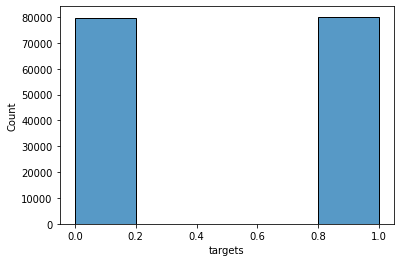

In [5]:
sns.histplot(df_sample, x='targets', binwidth = 0.2)

# Train test split

In [6]:
df_train = df_sample.sample(frac = 0.8, random_state = 1)
df_valid = df_sample[~df_sample.id.isin(df_train.id)]
df_test = df_valid.sample(frac = 0.5, random_state = 1)
df_valid = df_valid[~df_valid.id.isin(df_test.id)]

# Data preprocessing
* Eliminate handles and URLs

* Tokenize the string into words.

* Remove stop words like "and, is, a, on, etc."

* Stemming- or convert every word to its stem. Like dancer, dancing, danced, becomes 'danc'. You can use porter stemmer to take care of this.

* Convert all your words to lower case.

In [7]:
text_processer = TextProcessor()

In [8]:
df_cleaned_text = df_train.copy()
df_cleaned_text['text'] = df_cleaned_text.text.apply(lambda x: text_processer.clean(x))

In [9]:
pos_words = np.concatenate(df_cleaned_text[df_cleaned_text.targets == 1].text.values).ravel()
neg_words = np.concatenate(df_cleaned_text[df_cleaned_text.targets == 0].text.values).ravel()

In [10]:
pos_dict = utils.create_dict(pos_words)
neg_dict = utils.create_dict(neg_words)

In [11]:
def sum_freq(text, pos_dict, neg_dict):
    """
    count the frequency of positive and negtive words
    """
    pos_freq, neg_freq = 0, 0
    
    for word in text:
        if word in pos_dict:
            pos_freq += pos_dict[word]
        if word in neg_dict:
            neg_freq += neg_dict[word]
    return [1, pos_freq, neg_freq]

In [12]:
df_cleaned_text["vector"] = df_cleaned_text.text.apply(lambda x: sum_freq(x, pos_dict, neg_dict))
df_valid["vector"] = df_valid.text.apply(lambda x: sum_freq(x, pos_dict, neg_dict))
df_test["vector"] = df_test.text.apply(lambda x: sum_freq(x, pos_dict, neg_dict))

In [13]:
X_train, y_train = np.stack(df_cleaned_text.vector, axis = 0), np.array(df_cleaned_text.targets)
X_valid, y_valid = np.stack(df_valid.vector, axis = 0), np.array(df_valid.targets)
X_test, y_test = np.stack(df_test.vector, axis = 0), np.array(df_test.targets)

# Benchmark

In [22]:
model_baseline = sklearn.linear_model.LogisticRegression()
clf = model_baseline.fit(X_train, y_train)
clf.score(X_train, y_train)

0.67565625

# Logistic regression

In [15]:
class LogisticRegression():
    def compute_loss(self, y_hat, y):
        "binary cross entropy loss"
        epsilon = 1e-15
        loss = -1 * np.dot(y, np.log(y_hat + epsilon)) - np.dot((1 - y), np.log(1 - y_hat + epsilon))
        return np.mean(loss)
    
    def sigmoid(self, w, x):
        z = 1 / (1 + np.exp(-1 * np.dot(x, w)))
        return z
    
    def predict(self, y):
        if y > 0.5:
            return 1
        else:
            return 0

In [16]:
X_train

array([[    1,  1175,  2910],
       [    1,  8611,  9852],
       [    1, 10642, 20219],
       ...,
       [    1, 23530, 32413],
       [    1,  9229,  8149],
       [    1, 32035, 42795]])

In [18]:
X_train_new = X_train.copy()
X_valid_new = X_valid.copy()

In [21]:
w = np.random.rand(X_train.shape[1])
X_train_new = X_train / np.mean(X_train, 0)
X_valid_new = X_valid_new / np.mean(X_valid, 0)
train_losses = []
valid_losses = []
size = X_train_new.shape[0]
n_epoch = 1000
lr = 1
model = LogisticRegression()
for epoch in range(n_epoch):
    y_hat = model.sigmoid(w, X_train_new)
#     print(y_hat.sum())
    train_loss = model.compute_loss(y_hat, y_train) / size
    gradient = (1 / size) * np.dot(X_train_new.T, (y_hat - y_train))
    w = w - lr*gradient 
#     print(w)
    train_losses.append(train_loss)
    y_train_pred = y_hat >= 0.5
    train_accuracy = (y_train_pred == y_train).sum() / np.shape(X_train_new)[0]
    
    
    y_valid_hat = model.sigmoid(w, X_valid_new)
    valid_loss = model.compute_loss(y_valid_hat, y_valid) / X_valid_new.shape[0]
    y_valid_pred = y_valid_hat >= 0.5
    valid_losses.append(valid_loss)
    valid_accuracy = (y_valid_pred == y_valid).sum() / np.shape(X_valid_new)[0]
    if (epoch % 100) == 0:
#         print("train accuracy: {}".format(train_accuracy))
        print("loss on train data: {}, accuracy on train data: {}".format(train_loss, train_accuracy))
        print("loss on valid data: {}, accuracy on valid data: {} \n".format(valid_loss, valid_accuracy))

loss on train data: 0.9146174460984451, accuracy on train data: 0.50009375
loss on valid data: 0.6931928956200668, accuracy on valid data: 0.505501375343836 

loss on train data: 0.657926816804471, accuracy on train data: 0.6226953125
loss on valid data: 0.693615487446672, accuracy on valid data: 0.505501375343836 

loss on train data: 0.6443257433706672, accuracy on train data: 0.663328125
loss on valid data: 0.6930880344721692, accuracy on valid data: 0.505501375343836 

loss on train data: 0.636474080518771, accuracy on train data: 0.6669296875
loss on valid data: 0.6934442373050729, accuracy on valid data: 0.49449862465616407 

loss on train data: 0.6317620022740139, accuracy on train data: 0.6627109375
loss on valid data: 0.694127483570294, accuracy on valid data: 0.49449862465616407 

loss on train data: 0.6288440575625958, accuracy on train data: 0.6604609375
loss on valid data: 0.6948957579059007, accuracy on valid data: 0.49449862465616407 

loss on train data: 0.6269922022189

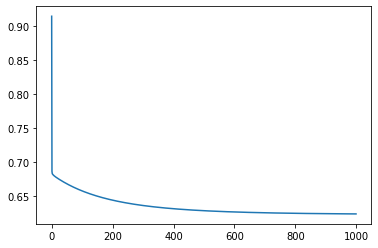

In [23]:
plt.plot(train_losses)

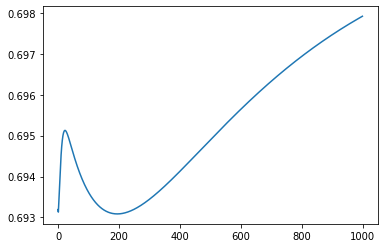

In [24]:
plt.plot(valid_losses)